# Классификация заемщиков линейными моделями, part 2

## курс "Машинное обучение 1", программа AIMasters, 2024

## Студент: <Введите ваше ФИО>

Эксперименты будем проводить на [датасете](https://www.kaggle.com/competitions/home-credit-default-risk/overview) по классификации заемщиков на плохих (target = 1: клиент с "payment difficulties") и хороших (target = 0: все остальные). 

Описание колонок находится в файле `description.csv`.

Для начала мы за вас считаем данные и поделим на обучение и тест.

Код в чтение, разбиение менять не нужно.

Выполняя задания, не забывайте про [устав](https://t.me/c/2206639786/270/271).

In [1]:
# не меняем код
import pandas as pd
import numpy as np
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150


data = pd.read_csv('application_train.csv')
data.columns = ['sk_id_curr', 'target'] + list(data.columns[2:])
data.head(3)

# не меняем код
test_idx = data.sk_id_curr % 10 >= 7
data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['tr'] = data.loc[~test_idx].reset_index(drop=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)
    
    from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer

import optuna

num_features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns
num_features
cat_features = data.select_dtypes('object').columns
cat_features, len(cat_features)

tst shape: (92221, 122)
tr shape: (215290, 122)


(Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
        'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
       dtype='object'),
 16)

In [ ]:
import sys
sys.path.append('F:/учебба/aimasters/utils')
from utils import plot_density, 

NameError: name 'np' is not defined

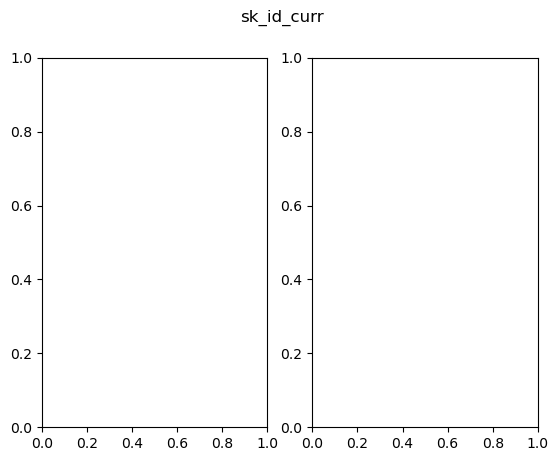

In [ ]:
import numpy as np

plot_density(data)

In [2]:
# не меняем код
test_idx = data.sk_id_curr % 10 >= 7
data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['tr'] = data.loc[~test_idx].reset_index(drop=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)

tst shape: (92221, 122)
tr shape: (215290, 122)


## Пайплайны (5 баллов)

Вам предлагается реализовать свой пайплайн предобработки данных + обучение линейной модели.

Примеры использования sklearn [pipeline](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html) можете найти в ноутбуке с семинара по предобработке.

Можно использовать все, что есть в https://scikit-learn.org/1.5/modules/preprocessing.html + оборачивать все в кастомные трансформеры (про них ниже).

На выходе у вас должна стоять линейная модель.

Любой код ниже **можно** менять.

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer

import optuna


In [ ]:
num_features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns
num_features
cat_features = data.select_dtypes('object').columns
cat_features, len(cat_features)

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=104)

In [5]:
cat_features = data.select_dtypes('object').columns
cat_features, len(cat_features)

(Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
        'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
        'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
       dtype='object'),
 16)

In [17]:
num_transformer = Pipeline([
    ('imp_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])
cat_transformer = Pipeline(steps=[
    ('imp_most_freq', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder()),
    #('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:

ct = ColumnTransformer(
    transformers=[
        ('num', num_transformer, list(num_features)),
        ('cat', cat_transformer, list(cat_features)),
    ]
)

In [17]:
pipeline = Pipeline([
    ('ct', ct),
])

In [18]:
pipeline.fit(data_dict['tr'])
new_tr = pipeline.transform(data_dict['tr'])

In [3]:
num_imputers = [
    SimpleImputer(strategy='mean'),
    SimpleImputer(strategy='median'),
    SimpleImputer(strategy='most_frequent'),
    SimpleImputer(strategy='constant', fill_value=0)
]
cat_imputers = [
    SimpleImputer(strategy='most_frequent'),
    SimpleImputer(strategy='constant', fill_value='missing')
]
scalers = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler(),
    MaxAbsScaler()
]
encoders = [
    OneHotEncoder(handle_unknown='ignore'),
    OrdinalEncoder()
]

In [4]:

def my_objective(trial: optuna.trial.Trial, 
                 X_tst, y_tst, X_trn, y_trn):
    params = {
        'num_imputer': trial.suggest_int('num_imputer', 0, 3),
        'cat_imputer': trial.suggest_int('cat_imputer', 0, 1),
        'scaler': trial.suggest_int('scaler', 0, 3),
        'encoder': trial.suggest_int('encoder', 0, 1),
    }
    regParams = {
        'C': trial.suggest_float('C', 0.001, 100),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000)
    }
    
    num_transformer = Pipeline(steps=[
                                    ('imputer', num_imputers[params['num_imputer']]),
                                    ('scaler', scalers[params['scaler']])])
    cat_transformer = Pipeline(steps=[
                                    ('imputer', cat_imputers[params['cat_imputer']]),
                                    ('encoder', encoders[params['encoder']])])
    ct = ColumnTransformer(
    transformers=[
        ('num', num_transformer, list(num_features)),
        ('cat', cat_transformer, list(cat_features)),
        ]
    )
    pipeline = Pipeline([
    ('ct', ct),
    ('logLR', LogisticRegression(**regParams)),
    ])
    pipeline.fit(X_trn, y_trn)
    score = roc_auc_score(y_tst, pipeline.predict_proba(X_tst)[:, 1])
    return score
    


In [ ]:
n_trials = 50
tpe_sampler = optuna.samplers.TPESampler(
    n_startup_trials=n_trials/2, # объем разведки. Всегда настраивайте!
    gamma=lambda n_trials: min(int(np.ceil(0.1 * n_trials)), 25), # не обязательно настраивать. По умолчанию топ-10%
    n_ei_candidates=13, # влияет на "точность шага"
)
study = optuna.create_study(sampler=tpe_sampler, direction='maximize')
from functools import partial
objective = partial(my_objective, X_trn=data_dict['tr'], y_trn=data_dict['tr'].target, X_tst=data_dict['tst'], y_tst=data_dict['tst'].target)
study.optimize(objective, n_trials=n_trials, n_jobs=5, gc_after_trial=True)

[I 2025-04-09 14:08:40,323] A new study created in memory with name: no-name-61ea0e3d-9d28-44af-aeea-3ff6adfcd60f
[I 2025-04-09 14:09:01,769] Trial 0 finished with value: 0.746153031600943 and parameters: {'num_imputer': 1, 'cat_imputer': 1, 'scaler': 0, 'encoder': 0, 'C': 20.718327746159048, 'penalty': 'l2', 'max_iter': 2940}. Best is trial 0 with value: 0.746153031600943.
[I 2025-04-09 14:09:14,865] Trial 2 finished with value: 0.7377546249358795 and parameters: {'num_imputer': 2, 'cat_imputer': 0, 'scaler': 1, 'encoder': 0, 'C': 59.57586007251016, 'penalty': 'l2', 'max_iter': 3129}. Best is trial 0 with value: 0.746153031600943.
[I 2025-04-09 14:09:36,074] Trial 6 finished with value: 0.7465095263619549 and parameters: {'num_imputer': 0, 'cat_imputer': 0, 'scaler': 0, 'encoder': 0, 'C': 75.63455350177072, 'penalty': 'l2', 'max_iter': 1543}. Best is trial 6 with value: 0.7465095263619549.
[I 2025-04-09 14:09:47,304] Trial 5 finished with value: 0.7372872120640336 and parameters: {'nu

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(data_dict['tst'].target, pipeline.predict_proba(data_dict['tst'])[:, 1])

### Кастомные трансформеры

В этом пункте вам нужно добавить один любой кастомный трансформер данных. (можно больше, минимум 1)

Примеры кастомных трансформеров можно найти
- в семинаре по предобработке
- https://www.andrewvillazon.com/custom-scikit-learn-transformers/
- https://medium.com/@pgshanding/creating-custom-transformers-in-python-and-scikit-learn-10767487017e
- в интернете :)

Варианты трансформеров
- генерация новых признаков, примеры новых признаков можно найти в соревновании с kaggle, откуда был взят датасет https://www.kaggle.com/competitions/home-credit-default-risk/code?competitionId=9120&sortBy=voteCount&excludeNonAccessedDatasources=true, т.е. ваш трансформер принимает на вход pd.DataFrame и добавляет новые колонки с признаками
- категорийные энкодеры, которые не реализованы в sklearn, можно взять готовые реализации и обернуть их в свой трансформер. Примеры категорийных энкодеров - https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark, примеры реализаций - https://contrib.scikit-learn.org/category_encoders/ (если не требуется дополнительный код для использования в вашем пайплайне, можете использовать as is)
- замена пропусков от SimpleImputer с добавлением нового признака, что был пропуск 
- эмбединг текста из одного/нескольких признаков
- любой другой ваш вариант, который дает результат

Не забудьте добавить комментарий, что делает ваш трансформер.

In [ ]:
# ваш код

Выбейте на тесте больше `0.752` [roc_auc_score](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.roc_auc_score.html).
Для поиска лучшей модели можно использовать:
- optuna
- [GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)
- свои наблюдения и интуицию

In [ ]:
# ваш код

### Бонусы (до +5 баллов)

За вашу работу можно получить до 5 бонусных баллов <br>
За какие заслуги можно получить бонус:
- скор на тесте значительно больше 0.752 (будет сравниваться с другими работами студентов)
- интересные реализации кастомных трансформеров
- интересные находки в данных, которые увеличили вам скор. Опишите, что вы нашли и как это помогло увеличить скор.
- см. пункт "Хорошие работы" в [уставе](https://t.me/c/2206639786/270/271) 

In [ ]:
# ваш код